In [1]:
from melee_dataset import MeleeDataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.distributions import Categorical
from torch.distributions import Bernoulli,Normal
import matplotlib.pyplot as plt
from PolicyNet import PolicyNet
import torch.nn.functional as F
from Agents.BCAgent import BCAgent

%load_ext autoreload
%autoreload 2

In [2]:
# train_dataset = MeleeDataset(data_path="data/train_mini_515")
# train_dataset = MeleeDataset(data_path="data/train_mini_40")
train_dataset = MeleeDataset(data_path="data/train_mini_5")
# train_dataset = MeleeDataset(data_path="data/train_mini_10_with_hitstun")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = MeleeDataset(data_path="data/val_mini_1")
# val_dataset = MeleeDataset(data_path="data/val_mini_10")
# val_dataset = MeleeDataset(data_path="data/val_mini_2_with_hitstun")
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)


In [3]:
print(f"obs_dim: {train_dataset[0][0].shape}")
print(f"act_dim: {train_dataset[0][1].shape}")

obs_dim: torch.Size([70])
act_dim: torch.Size([17])


In [43]:

from Agents.BCAgent import BCAgent
from Agents.IQLAgent import IQLAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
obs_dim = train_dataset[0][0].shape[0]
act_dim = train_dataset[0][1].shape[0]
# agent = BCAgent(obs_dim, act_dim, device)
agent = IQLAgent(obs_dim, act_dim, device, param_update_freq=100)

# set the seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

losses = []
val_losses = []
batch_cnt = 0
for epoch in range(5):
    total_loss = 0.0
    for i, (states, actions, next_states) in tqdm(enumerate(train_loader)):
        states = states.to(device)       # [B, obs_dim]
        actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        next_states = next_states.to(device)
        # for i in range(1000):
        loss = agent.train(states, actions, next_states)
        vl, ql, pl = loss
        # print(loss)
        losses.append(loss)
        # break
        total_loss += pl * states.shape[0]
        batch_cnt += 1

        # if batch_cnt % 100 == 0:
        #     val_loss = 0.0  
        #     for i, (states, actions, next_states) in tqdm(enumerate(val_loader)):
        #         states = states.to(device)       # [B, obs_dim]
        #         actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        #         next_states = next_states.to(device)

        #         val_loss += agent.validate(states, actions)
        #     avg_val_loss = val_loss / len(val_dataset)
        #     val_losses.append(avg_val_loss)
        #     print(f"Epoch {epoch+1} — Val Loss: {avg_val_loss:.4f}")
    # break

    avg_loss = total_loss / len(train_dataset)
    # losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")




Using device: cuda


355it [00:02, 176.46it/s]


Epoch 1 — Loss: 955.1092


355it [00:01, 204.10it/s]


Epoch 2 — Loss: 1.1345


355it [00:01, 187.67it/s]


Epoch 3 — Loss: -68.0453


355it [00:02, 174.30it/s]


Epoch 4 — Loss: -106.0191


355it [00:01, 196.27it/s]

Epoch 5 — Loss: -127.6494


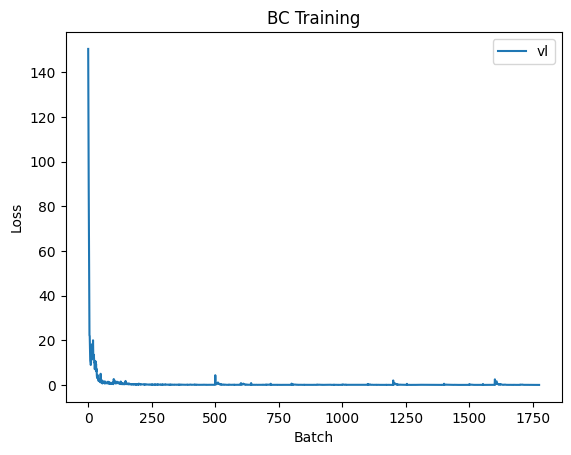

In [46]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.title("BC Training")
plt.xlabel("Batch")
plt.ylabel("Loss")
# plt.xticks(np.arange(0, 6, 1))
# plt.yscale("log")
plt.plot([losses[i][0] for i in range(len(losses))], label="vl")
# plt.plot([losses[i][1] for i in range(len(losses))], label="ql")
# plt.plot([losses[i][2] for i in range(len(losses))], label="pl")
# plt.plot(losses, label="train loss")
# plt.plot([100 * i for i in range(1, len(val_losses)+1)], val_losses, label="val loss")
plt.legend()
plt.show()



In [47]:
# Save the trained model
torch.save(agent.policy.state_dict(), "iql_5.pth")
# torch.save(agent.policy_net.state_dict(), "iql_5.pth")
print("Model saved to trained_policy.pth")


Model saved to trained_policy.pth
